In [17]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from scipy.stats import boxcox
from plotnine import *
from plotnine import ggplot, aes, geom_line
from pmdarima.arima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
from tqdm.notebook import tqdm

In [18]:
# pd.set_option('display.max_rows', None)
# pd.set_option('display.max_columns', None)

## Pre-process Data

In [19]:
# Load Data
calendar = pd.read_csv("Data/calendar_afcs2020.csv")
sales = pd.read_csv("Data/sales_train_evaluation_afcs2020.csv")
train = pd.read_csv("Data/sales_train_validation_afcs2020.csv")
sample_submission = pd.read_csv("Data/sample_submission_afcs2020.csv")
price = pd.read_csv("Data/sell_prices_afcs2020.csv")

In [20]:
# Convert days into dates
calendar['date'] = pd.to_datetime(calendar['date'])
datetime = calendar[["date","d"]].copy()

In [27]:
price["id"] = price["item_id"] + "_" + price["store_id"] + "_validation"

In [31]:
# Visualization
# plt.figure(figsize=(12,12))
        
# plt.plot(ts_train["ds"],ts_train["y"],label="Train")
# plt.plot(ts_test["ds"],ts_test["y"],label="Test")
# plt.plot(ts_test["ds"],pred,label="Forecast")
# plt.title("Time Series Forecasting")
# plt.legend()

## Forecast function

In [32]:
def forecast(h, MA=False, season_naive=False, auto_ARIMA=False):
    """Forecast based on historical sales of items"""
    
    # Do nothing if no forecast is selected
    if not MA and not season_naive and not auto_arima_f:
        print ("No forecast has been made")
        return 0
    
    # Set parameters
    output = {}

    # Forecast sales per product item
#     for i in range(1, len(train) + 1):
    for i in tqdm(range(1, len(train) + 1)):
        fc = []
        
        # Create train data per item and merge with datetime
        item_train = train.iloc[(i-1):i].iloc[:,1:].T.reset_index()
        item_train = pd.merge(left=item_train,right=datetime,left_on="index",right_on="d",how="left")
        item_train.drop(["d","index"],axis=1,inplace=True)
        item_train = item_train.rename({"date":"ds",item_train.columns[0]:"y"},axis=1)
        item_train = item_train[item_train.columns[::-1]]
        
        # Create test data per item and merge with datetime
        item_sales = sales.iloc[(i-1):i][sales.columns[-(h+1):]].iloc[:,1:].T.reset_index()
        item_sales = pd.merge(left=item_sales,right=datetime,left_on="index",right_on="d",how="left")
        item_sales.drop(["d","index"],axis=1,inplace=True)
        item_sales = item_sales.rename({"date":"ds",item_sales.columns[0]:"y"},axis=1)

        # Create time series of train and test data
        ts_train = item_train.iloc[-int(h/2*8):,:].copy()
        ts_test = item_sales[item_sales.columns[::-1]]
    
    
    
        # Forecast using Moving Average
        if MA:
            fc_str = "MA"
            data = ts_train["y"].tolist()
            pred = moving_average(data, h)[1:]
        
        if season_naive:
            fc_str = "season_naive"
            data = ts_train.set_index("ds")["y"]
            pred = s_naive(data, h)
            
        if auto_ARIMA:
            fc_str = "auto_arima"
            data = ts_train["y"].tolist()
            pred = auto_arima_f(data, h)
        
        # Create output
        fc.append(train.id[(i-1)])
        fc.extend(pred)
        output[(i-1)] = fc
        


    # Convert output to dataframe
    output_df = pd.DataFrame.from_dict(output, orient='index', columns=sample_submission.columns)
    output_df.to_csv('Output/output_{}.csv'.format(fc_str), index=False)
    
    return output_df

## Forecast Models

#### Moving Average Forecast (0.90348)

https://machinelearningmastery.com/time-series-forecasting-methods-in-python-cheat-sheet/

In [29]:
# Moving Average (MA)
def moving_average(train, h):
    
    # fit model
    model = ARIMA(train, order=(0, 0, 1))
    model_fit = model.fit()
    
    # make prediction
    start_index = len(train) + 1
    end_index = start_index + h
    fc = model_fit.predict(start=start_index, end=end_index)
    
    return fc

C:\Users\Rijksbaron\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
C:\Users\Rijksbaron\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
C:\Users\Rijksbaron\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
C:\Users\Rijksbaron\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
C:\Users\Rijksbaron\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
C:\Users\Rijksbaron\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Chec

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,...,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,HOBBIES_2_001_CA_3_validation,0.115786,0.115786,0.115786,0.115786,0.115786,0.115786,0.115786,0.115786,0.115786,...,0.115786,0.115786,0.115786,0.115786,0.115786,0.115786,0.115786,0.115786,0.115786,0.115786
1,HOBBIES_2_002_CA_3_validation,0.178493,0.178493,0.178493,0.178493,0.178493,0.178493,0.178493,0.178493,0.178493,...,0.178493,0.178493,0.178493,0.178493,0.178493,0.178493,0.178493,0.178493,0.178493,0.178493
2,HOBBIES_2_003_CA_3_validation,0.670597,0.670597,0.670597,0.670597,0.670597,0.670597,0.670597,0.670597,0.670597,...,0.670597,0.670597,0.670597,0.670597,0.670597,0.670597,0.670597,0.670597,0.670597,0.670597
3,HOBBIES_2_004_CA_3_validation,0.257982,0.257982,0.257982,0.257982,0.257982,0.257982,0.257982,0.257982,0.257982,...,0.257982,0.257982,0.257982,0.257982,0.257982,0.257982,0.257982,0.257982,0.257982,0.257982
4,HOBBIES_2_005_CA_3_validation,0.089517,0.089517,0.089517,0.089517,0.089517,0.089517,0.089517,0.089517,0.089517,...,0.089517,0.089517,0.089517,0.089517,0.089517,0.089517,0.089517,0.089517,0.089517,0.089517
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
144,HOBBIES_2_145_CA_3_validation,0.437722,0.437722,0.437722,0.437722,0.437722,0.437722,0.437722,0.437722,0.437722,...,0.437722,0.437722,0.437722,0.437722,0.437722,0.437722,0.437722,0.437722,0.437722,0.437722
145,HOBBIES_2_146_CA_3_validation,0.122272,0.122272,0.122272,0.122272,0.122272,0.122272,0.122272,0.122272,0.122272,...,0.122272,0.122272,0.122272,0.122272,0.122272,0.122272,0.122272,0.122272,0.122272,0.122272
146,HOBBIES_2_147_CA_3_validation,0.330087,0.330087,0.330087,0.330087,0.330087,0.330087,0.330087,0.330087,0.330087,...,0.330087,0.330087,0.330087,0.330087,0.330087,0.330087,0.330087,0.330087,0.330087,0.330087
147,HOBBIES_2_148_CA_3_validation,0.240225,0.240225,0.240225,0.240225,0.240225,0.240225,0.240225,0.240225,0.240225,...,0.240225,0.240225,0.240225,0.240225,0.240225,0.240225,0.240225,0.240225,0.240225,0.240225


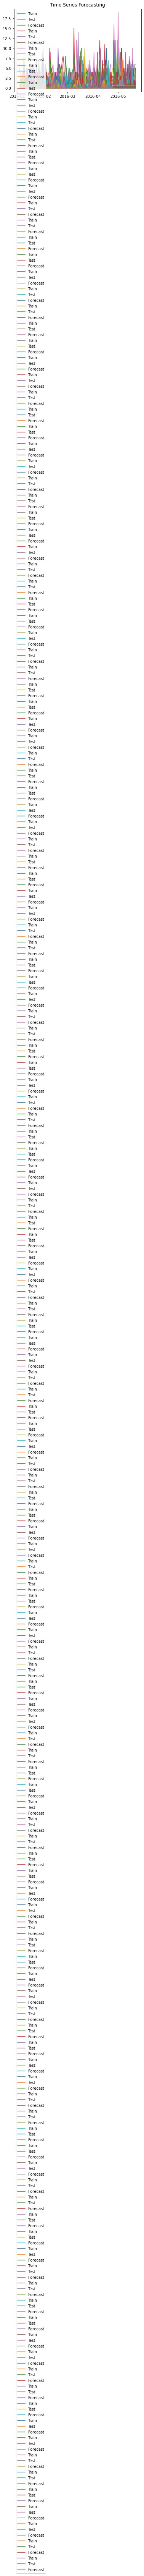

In [30]:
forecast(28, MA=True)

#### Seasonal Naive (Score: 1.15463)

https://pawarbi.github.io/blog/forecasting/r/python/rpy2/altair/fbprophet/ensemble_forecast/uncertainty/simulation/2020/04/21/timeseries-part2.html#Importing-libraries

In [12]:
def pysnaive(train_series,seasonal_periods,forecast_horizon):    
    '''
    Python implementation of Seasonal Naive Forecast. 
    This should work similar to https://otexts.com/fpp2/simple-methods.html
    Returns two arrays
     > fitted: Values fitted to the training dataset
     > fcast: seasonal naive forecast
    
    Author: Sandeep Pawar
    
    Date: Apr 9, 2020
    
    Ver: 1.0
    
    train_series: Pandas Series
        Training Series to be used for forecasting. This should be a valid Pandas Series. 
        Length of the Training set should be greater than or equal to number of seasonal periods
        
    Seasonal_periods: int
        No of seasonal periods
        Yearly=1
        Quarterly=4
        Monthly=12
        Weekly=52
        

    Forecast_horizon: int
        Number of values to forecast into the future
    
    e.g. 
    fitted_values = pysnaive(train,12,12)[0]
    fcast_values = pysnaive(train,12,12)[1]
    '''
    
    if len(train_series)>= seasonal_periods: #checking if there are enough observations in the training data
        
        last_season=train_series.iloc[-seasonal_periods:]
        
        reps=np.int(np.ceil(forecast_horizon/seasonal_periods))
        
        fcarray=np.tile(last_season,reps)
        
        fcast=pd.Series(fcarray[:forecast_horizon])
        
        fitted = train_series.shift(seasonal_periods)
        
    else:
        fcast=print("Length of the trainining set must be greater than number of seasonal periods") 
    
    return fitted, fcast


def s_naive(data, h):
    """Call the Season Naive function"""
    
    # Fitted values
    py_snaive_fit = pysnaive(data, 
                         seasonal_periods=7,
                         forecast_horizon=h)[0]

    # Forecast 
    py_snaive = pysnaive(data, 
                         seasonal_periods=7,
                         forecast_horizon=h)[1]

    #Residuals
    py_snaive_resid = (data - py_snaive_fit).dropna()
    
    # Predict Season Naive
    pred = py_snaive.values
    
    return pred

In [13]:
forecast(28, season_naive=True)

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,...,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,HOBBIES_2_001_CA_3_validation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,HOBBIES_2_002_CA_3_validation,0,0,0,1,1,0,0,0,0,...,1,0,0,0,0,0,1,1,0,0
2,HOBBIES_2_003_CA_3_validation,0,0,0,1,0,1,3,0,0,...,0,1,3,0,0,0,1,0,1,3
3,HOBBIES_2_004_CA_3_validation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,HOBBIES_2_005_CA_3_validation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
144,HOBBIES_2_145_CA_3_validation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
145,HOBBIES_2_146_CA_3_validation,0,0,0,0,0,3,0,0,0,...,0,3,0,0,0,0,0,0,3,0
146,HOBBIES_2_147_CA_3_validation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
147,HOBBIES_2_148_CA_3_validation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### Auto Arima (Score: 1.13422)

https://towardsdatascience.com/time-series-forecasting-using-auto-arima-in-python-bb83e49210cd

In [14]:
def auto_arima_f(data, h):
    arima_model =  auto_arima(data,start_p=0, d=1, start_q=0, 
                              max_p=5, max_d=5, max_q=5, start_P=0, 
                              D=1, start_Q=0, max_P=5, max_D=5,
                              max_Q=5, m=12, seasonal=True, 
                              error_action='warn',trace = True,
                              supress_warnings=True,stepwise = True,
                              random_state=20,n_fits = 50)
    
    pred = arima_model.predict(n_periods = h)
    
    return pred

# Set Trace to False to print no output

In [15]:
forecast(28, auto_ARIMA=True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=217.284, Time=0.01 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=164.720, Time=0.07 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.27 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=194.868, Time=0.02 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=155.232, Time=0.17 sec
 ARIMA(1,1,0)(3,1,0)[12]             : AIC=153.136, Time=0.40 sec
 ARIMA(1,1,0)(4,1,0)[12]             : AIC=148.283, Time=1.03 sec
 ARIMA(1,1,0)(5,1,0)[12]             : AIC=150.262, Time=2.84 sec
 ARIMA(1,1,0)(4,1,1)[12]             : AIC=149.856, Time=2.32 sec
 ARIMA(1,1,0)(3,1,1)[12]             : AIC=inf, Time=2.51 sec
 ARIMA(1,1,0)(5,1,1)[12]             : AIC=151.631, Time=8.35 sec
 ARIMA(0,1,0)(4,1,0)[12]             : AIC=167.450, Time=0.79 sec
 ARIMA(2,1,0)(4,1,0)[12]             : AIC=142.548, Time=0.92 sec
 ARIMA(2,1,0)(3,1,0)[12]             : AIC=146.520, Time=0.63 sec
 ARIMA(2,1,0)(5,1,0)[12]             : AI

 ARIMA(1,1,1)(3,1,0)[12]             : AIC=294.125, Time=1.06 sec
 ARIMA(1,1,1)(5,1,0)[12]             : AIC=288.513, Time=5.18 sec
 ARIMA(1,1,1)(4,1,1)[12]             : AIC=inf, Time=4.59 sec
 ARIMA(1,1,1)(3,1,1)[12]             : AIC=inf, Time=2.86 sec
 ARIMA(1,1,1)(5,1,1)[12]             : AIC=inf, Time=16.37 sec
 ARIMA(0,1,1)(4,1,0)[12]             : AIC=287.547, Time=1.17 sec
 ARIMA(0,1,1)(3,1,0)[12]             : AIC=293.090, Time=0.70 sec
 ARIMA(0,1,1)(5,1,0)[12]             : AIC=287.594, Time=3.41 sec
 ARIMA(0,1,1)(4,1,1)[12]             : AIC=inf, Time=3.77 sec
 ARIMA(0,1,1)(3,1,1)[12]             : AIC=inf, Time=2.59 sec
 ARIMA(0,1,1)(5,1,1)[12]             : AIC=inf, Time=11.70 sec
 ARIMA(0,1,0)(4,1,0)[12]             : AIC=331.768, Time=0.61 sec
 ARIMA(0,1,2)(4,1,0)[12]             : AIC=288.057, Time=1.87 sec
 ARIMA(1,1,2)(4,1,0)[12]             : AIC=287.417, Time=2.16 sec
 ARIMA(1,1,2)(3,1,0)[12]             : AIC=292.312, Time=1.22 sec
 ARIMA(1,1,2)(5,1,0)[12]        

 ARIMA(3,1,0)(0,1,3)[12]             : AIC=311.178, Time=0.90 sec
 ARIMA(3,1,0)(1,1,1)[12]             : AIC=inf, Time=0.77 sec
 ARIMA(3,1,0)(1,1,3)[12]             : AIC=313.100, Time=1.06 sec
 ARIMA(4,1,0)(0,1,2)[12]             : AIC=309.778, Time=0.67 sec
 ARIMA(3,1,1)(0,1,2)[12]             : AIC=299.095, Time=0.94 sec
 ARIMA(3,1,1)(0,1,1)[12]             : AIC=inf, Time=0.78 sec
 ARIMA(3,1,1)(1,1,2)[12]             : AIC=301.094, Time=1.72 sec
 ARIMA(3,1,1)(0,1,3)[12]             : AIC=301.094, Time=1.82 sec
 ARIMA(3,1,1)(1,1,1)[12]             : AIC=299.423, Time=0.51 sec
 ARIMA(3,1,1)(1,1,3)[12]             : AIC=303.094, Time=1.85 sec
 ARIMA(2,1,1)(0,1,2)[12]             : AIC=297.317, Time=0.79 sec
 ARIMA(2,1,1)(0,1,1)[12]             : AIC=inf, Time=0.54 sec
 ARIMA(2,1,1)(1,1,2)[12]             : AIC=299.309, Time=1.43 sec
 ARIMA(2,1,1)(0,1,3)[12]             : AIC=299.308, Time=1.48 sec
 ARIMA(2,1,1)(1,1,1)[12]             : AIC=297.801, Time=0.43 sec
 ARIMA(2,1,1)(1,1,3)[1

C:\Users\Rijksbaron\anaconda3\lib\site-packages\pmdarima\arima\auto.py:460: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.


 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.35 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=202.122, Time=0.02 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=169.981, Time=0.21 sec
 ARIMA(1,1,0)(3,1,0)[12]             : AIC=170.274, Time=0.44 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=1.07 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=0.37 sec
 ARIMA(1,1,0)(3,1,1)[12]             : AIC=inf, Time=1.89 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=197.679, Time=0.12 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=165.138, Time=0.29 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=182.142, Time=0.07 sec
 ARIMA(2,1,0)(3,1,0)[12]             : AIC=164.152, Time=0.57 sec
 ARIMA(2,1,0)(4,1,0)[12]             : AIC=162.010, Time=1.10 sec
 ARIMA(2,1,0)(5,1,0)[12]             : AIC=161.485, Time=3.81 sec
 ARIMA(2,1,0)(5,1,1)[12]             : AIC=163.003, Time=6.30 sec
 ARIMA(2,1,0)(4,1,1)[12]             : AIC=161.430, Time=2.21 sec
 ARIMA(2,1,0)(3,1,1)[12]  

 ARIMA(3,1,0)(0,1,2)[12]             : AIC=168.981, Time=0.45 sec
 ARIMA(3,1,0)(1,1,2)[12]             : AIC=170.834, Time=0.77 sec
 ARIMA(2,1,0)(0,1,1)[12]             : AIC=174.308, Time=0.18 sec
 ARIMA(4,1,0)(0,1,1)[12]             : AIC=170.019, Time=0.24 sec
 ARIMA(3,1,1)(0,1,1)[12]             : AIC=inf, Time=0.70 sec
 ARIMA(2,1,1)(0,1,1)[12]             : AIC=inf, Time=0.55 sec
 ARIMA(4,1,1)(0,1,1)[12]             : AIC=inf, Time=0.74 sec
 ARIMA(3,1,0)(0,1,1)[12] intercept   : AIC=170.486, Time=0.30 sec

Best model:  ARIMA(3,1,0)(0,1,1)[12]          
Total fit time: 13.083 seconds
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=230.017, Time=0.01 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=201.912, Time=0.06 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.45 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=215.248, Time=0.01 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=189.736, Time=0.17 sec
 ARIMA(1,1,0)(3,1,0)[12]            

 ARIMA(4,1,2)(4,1,0)[12] intercept   : AIC=135.098, Time=19.63 sec

Best model:  ARIMA(4,1,2)(4,1,0)[12]          
Total fit time: 454.377 seconds
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=274.608, Time=0.01 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=228.116, Time=0.11 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=181.130, Time=0.24 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=inf, Time=0.10 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=182.987, Time=0.29 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=inf, Time=0.81 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=188.940, Time=0.15 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=184.980, Time=1.57 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=inf, Time=0.14 sec
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=183.047, Time=0.38 sec
 ARIMA(0,1,2)(0,1,1)[12]             : AIC=183.030, Time=0.37 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=218.786, Time=0.15 sec
 ARIMA(1,1,2)(0,1,1)[12]      

C:\Users\Rijksbaron\anaconda3\lib\site-packages\pmdarima\arima\auto.py:460: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
C:\Users\Rijksbaron\anaconda3\lib\site-packages\pmdarima\arima\auto.py:460: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.


 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.33 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=182.424, Time=0.02 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=149.004, Time=0.21 sec
 ARIMA(1,1,0)(3,1,0)[12]             : AIC=146.547, Time=0.52 sec
 ARIMA(1,1,0)(4,1,0)[12]             : AIC=148.277, Time=0.97 sec
 ARIMA(1,1,0)(3,1,1)[12]             : AIC=148.300, Time=1.06 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=0.90 sec
 ARIMA(1,1,0)(4,1,1)[12]             : AIC=150.263, Time=1.68 sec
 ARIMA(0,1,0)(3,1,0)[12]             : AIC=157.797, Time=0.34 sec
 ARIMA(2,1,0)(3,1,0)[12]             : AIC=129.237, Time=0.64 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=130.264, Time=0.29 sec
 ARIMA(2,1,0)(4,1,0)[12]             : AIC=131.154, Time=1.05 sec
 ARIMA(2,1,0)(3,1,1)[12]             : AIC=inf, Time=2.56 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=inf, Time=1.69 sec
 ARIMA(2,1,0)(4,1,1)[12]             : AIC=inf, Time=5.90 sec
 ARIMA(3,1,0)(3,1,0)[12]      

 ARIMA(4,1,1)(4,1,0)[12]             : AIC=181.473, Time=4.62 sec
 ARIMA(4,1,1)(3,1,1)[12]             : AIC=inf, Time=4.22 sec
 ARIMA(4,1,1)(2,1,1)[12]             : AIC=inf, Time=2.71 sec
 ARIMA(4,1,1)(4,1,1)[12]             : AIC=inf, Time=15.15 sec
 ARIMA(3,1,1)(3,1,0)[12]             : AIC=184.032, Time=1.10 sec
 ARIMA(4,1,2)(3,1,0)[12]             : AIC=181.322, Time=1.90 sec
 ARIMA(3,1,2)(3,1,0)[12]             : AIC=182.569, Time=2.09 sec
 ARIMA(5,1,2)(3,1,0)[12]             : AIC=183.134, Time=1.67 sec
 ARIMA(4,1,1)(3,1,0)[12] intercept   : AIC=180.894, Time=2.41 sec

Best model:  ARIMA(4,1,1)(3,1,0)[12]          
Total fit time: 171.049 seconds
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=435.668, Time=0.01 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=384.605, Time=0.06 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.20 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=405.765, Time=0.01 sec
 ARIMA(1,1,0)(2,1,0)[12]          

 ARIMA(3,1,0)(4,1,1)[12]             : AIC=75.239, Time=4.43 sec
 ARIMA(4,1,0)(3,1,0)[12]             : AIC=70.016, Time=0.86 sec
 ARIMA(4,1,0)(2,1,0)[12]             : AIC=81.701, Time=0.57 sec
 ARIMA(4,1,0)(4,1,0)[12]             : AIC=71.635, Time=3.52 sec
 ARIMA(4,1,0)(3,1,1)[12]             : AIC=71.657, Time=2.13 sec
 ARIMA(4,1,0)(2,1,1)[12]             : AIC=73.763, Time=1.22 sec
 ARIMA(4,1,0)(4,1,1)[12]             : AIC=73.630, Time=9.97 sec
 ARIMA(5,1,0)(3,1,0)[12]             : AIC=51.665, Time=1.45 sec
 ARIMA(5,1,0)(2,1,0)[12]             : AIC=64.544, Time=0.90 sec
 ARIMA(5,1,0)(4,1,0)[12]             : AIC=51.534, Time=5.21 sec
 ARIMA(5,1,0)(5,1,0)[12]             : AIC=53.284, Time=6.76 sec
 ARIMA(5,1,0)(4,1,1)[12]             : AIC=53.297, Time=14.09 sec
 ARIMA(5,1,0)(3,1,1)[12]             : AIC=51.458, Time=3.09 sec
 ARIMA(5,1,0)(2,1,1)[12]             : AIC=54.728, Time=2.17 sec
 ARIMA(5,1,0)(3,1,2)[12]             : AIC=52.470, Time=5.12 sec
 ARIMA(5,1,0)(2,1,2)[12]

C:\Users\Rijksbaron\anaconda3\lib\site-packages\pmdarima\arima\auto.py:460: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.


 ARIMA(0,1,1)(0,1,1)[12]             : AIC=191.098, Time=0.16 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=233.361, Time=0.03 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=188.470, Time=0.52 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=196.391, Time=0.09 sec
 ARIMA(0,1,1)(2,1,1)[12]             : AIC=190.467, Time=0.59 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=188.273, Time=0.73 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=188.361, Time=0.42 sec
 ARIMA(0,1,1)(2,1,2)[12]             : AIC=inf, Time=1.21 sec
 ARIMA(0,1,1)(1,1,3)[12]             : AIC=inf, Time=2.25 sec
 ARIMA(0,1,1)(0,1,3)[12]             : AIC=190.325, Time=0.58 sec
 ARIMA(0,1,1)(2,1,3)[12]             : AIC=inf, Time=2.87 sec
 ARIMA(0,1,0)(1,1,2)[12]             : AIC=216.215, Time=0.50 sec
 ARIMA(1,1,1)(1,1,2)[12]             : AIC=inf, Time=1.60 sec
 ARIMA(0,1,2)(1,1,2)[12]             : AIC=inf, Time=1.67 sec
 ARIMA(1,1,0)(1,1,2)[12]             : AIC=211.846, Time=0.60 sec
 ARIMA(1,1,2)(1,1,2)[12]      

 ARIMA(2,1,0)(3,1,0)[12]             : AIC=109.499, Time=0.73 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=123.132, Time=0.33 sec
 ARIMA(2,1,0)(4,1,0)[12]             : AIC=109.597, Time=1.24 sec
 ARIMA(2,1,0)(3,1,1)[12]             : AIC=109.027, Time=1.59 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=inf, Time=0.90 sec
 ARIMA(2,1,0)(4,1,1)[12]             : AIC=111.750, Time=1.74 sec
 ARIMA(2,1,0)(3,1,2)[12]             : AIC=110.918, Time=1.87 sec
 ARIMA(2,1,0)(2,1,2)[12]             : AIC=109.804, Time=1.22 sec
 ARIMA(2,1,0)(4,1,2)[12]             : AIC=112.856, Time=5.29 sec
 ARIMA(3,1,0)(3,1,1)[12]             : AIC=98.559, Time=2.55 sec
 ARIMA(3,1,0)(2,1,1)[12]             : AIC=inf, Time=1.97 sec
 ARIMA(3,1,0)(3,1,0)[12]             : AIC=100.930, Time=1.09 sec
 ARIMA(3,1,0)(4,1,1)[12]             : AIC=101.234, Time=5.74 sec
 ARIMA(3,1,0)(3,1,2)[12]             : AIC=inf, Time=3.97 sec
 ARIMA(3,1,0)(2,1,0)[12]             : AIC=112.246, Time=0.44 sec
 ARIMA(3,1,0)(2,1,2)[12

 ARIMA(1,1,0)(3,1,0)[12]             : AIC=306.142, Time=0.38 sec
 ARIMA(1,1,0)(4,1,0)[12]             : AIC=306.985, Time=0.77 sec
 ARIMA(1,1,0)(3,1,1)[12]             : AIC=inf, Time=1.43 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=304.108, Time=0.43 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=0.41 sec
 ARIMA(1,1,0)(2,1,2)[12]             : AIC=306.058, Time=0.68 sec
 ARIMA(1,1,0)(1,1,2)[12]             : AIC=inf, Time=0.65 sec
 ARIMA(1,1,0)(3,1,2)[12]             : AIC=308.086, Time=1.26 sec
 ARIMA(0,1,0)(2,1,1)[12]             : AIC=315.679, Time=0.33 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=283.374, Time=0.70 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=inf, Time=0.66 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=289.874, Time=0.34 sec
 ARIMA(2,1,0)(3,1,1)[12]             : AIC=inf, Time=2.90 sec
 ARIMA(2,1,0)(2,1,2)[12]             : AIC=inf, Time=1.68 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=313.407, Time=0.08 sec
 ARIMA(2,1,0)(1,1,2)[12]          

 ARIMA(1,1,0)(3,1,0)[12]             : AIC=505.741, Time=0.36 sec
 ARIMA(1,1,0)(4,1,0)[12]             : AIC=487.655, Time=0.98 sec
 ARIMA(1,1,0)(5,1,0)[12]             : AIC=489.544, Time=2.62 sec
 ARIMA(1,1,0)(4,1,1)[12]             : AIC=489.470, Time=1.64 sec
 ARIMA(1,1,0)(3,1,1)[12]             : AIC=inf, Time=2.05 sec
 ARIMA(1,1,0)(5,1,1)[12]             : AIC=491.291, Time=7.71 sec
 ARIMA(0,1,0)(4,1,0)[12]             : AIC=499.810, Time=0.68 sec
 ARIMA(2,1,0)(4,1,0)[12]             : AIC=482.881, Time=1.21 sec
 ARIMA(2,1,0)(3,1,0)[12]             : AIC=500.968, Time=0.48 sec
 ARIMA(2,1,0)(5,1,0)[12]             : AIC=484.868, Time=2.88 sec
 ARIMA(2,1,0)(4,1,1)[12]             : AIC=484.864, Time=2.03 sec
 ARIMA(2,1,0)(3,1,1)[12]             : AIC=inf, Time=2.65 sec
 ARIMA(2,1,0)(5,1,1)[12]             : AIC=486.832, Time=9.70 sec
 ARIMA(3,1,0)(4,1,0)[12]             : AIC=484.702, Time=1.47 sec
 ARIMA(2,1,1)(4,1,0)[12]             : AIC=inf, Time=4.68 sec
 ARIMA(1,1,1)(4,1,0)[1

 ARIMA(5,1,0)(2,1,1)[12]             : AIC=inf, Time=2.59 sec
 ARIMA(5,1,0)(1,1,2)[12]             : AIC=214.393, Time=1.91 sec
 ARIMA(5,1,0)(0,1,0)[12]             : AIC=260.911, Time=0.06 sec
 ARIMA(5,1,0)(0,1,2)[12]             : AIC=inf, Time=0.97 sec
 ARIMA(5,1,0)(2,1,0)[12]             : AIC=217.153, Time=0.47 sec
 ARIMA(5,1,0)(2,1,2)[12]             : AIC=inf, Time=3.03 sec
 ARIMA(5,1,1)(1,1,1)[12]             : AIC=214.594, Time=1.59 sec
 ARIMA(4,1,1)(1,1,1)[12]             : AIC=inf, Time=1.20 sec
 ARIMA(5,1,0)(1,1,1)[12] intercept   : AIC=214.842, Time=0.73 sec

Best model:  ARIMA(5,1,0)(1,1,1)[12]          
Total fit time: 41.596 seconds
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=266.684, Time=0.01 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=244.307, Time=0.06 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.15 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=252.040, Time=0.01 sec
 ARIMA(1,1,0)(2,1,0)[12]             : A

C:\Users\Rijksbaron\anaconda3\lib\site-packages\pmdarima\arima\_auto_solvers.py:522: ModelFitWarning: Error fitting  ARIMA(2,1,0)(5,1,1)[12]           (if you do not want to see these warnings, run with error_action="ignore").


 ARIMA(2,1,0)(5,1,1)[12]             : AIC=inf, Time=nan sec
 ARIMA(2,1,0)(4,1,2)[12]             : AIC=inf, Time=5.60 sec
 ARIMA(2,1,0)(3,1,2)[12]             : AIC=inf, Time=3.40 sec
 ARIMA(2,1,0)(5,1,0)[12]             : AIC=226.297, Time=3.91 sec
 ARIMA(3,1,0)(5,1,0)[12]             : AIC=220.365, Time=4.02 sec
 ARIMA(3,1,0)(4,1,0)[12]             : AIC=222.416, Time=1.25 sec
 ARIMA(3,1,0)(5,1,1)[12]             : AIC=222.195, Time=16.33 sec
 ARIMA(3,1,0)(4,1,1)[12]             : AIC=221.739, Time=4.34 sec
 ARIMA(4,1,0)(5,1,0)[12]             : AIC=219.171, Time=4.55 sec
 ARIMA(4,1,0)(4,1,0)[12]             : AIC=219.384, Time=2.65 sec
 ARIMA(4,1,0)(5,1,1)[12]             : AIC=221.156, Time=19.97 sec
 ARIMA(4,1,0)(4,1,1)[12]             : AIC=220.055, Time=9.93 sec
 ARIMA(5,1,0)(5,1,0)[12]             : AIC=221.127, Time=5.45 sec
 ARIMA(4,1,1)(5,1,0)[12]             : AIC=inf, Time=16.47 sec
 ARIMA(3,1,1)(5,1,0)[12]             : AIC=218.311, Time=6.96 sec
 ARIMA(3,1,1)(4,1,0)[12]

 ARIMA(0,1,2)(4,1,0)[12] intercept   : AIC=inf, Time=4.98 sec

Best model:  ARIMA(0,1,2)(4,1,0)[12]          
Total fit time: 249.982 seconds
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=247.210, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=212.108, Time=0.12 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.43 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=235.201, Time=0.01 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=203.071, Time=0.19 sec
 ARIMA(1,1,0)(3,1,0)[12]             : AIC=204.321, Time=0.43 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=1.25 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=0.40 sec
 ARIMA(1,1,0)(3,1,1)[12]             : AIC=inf, Time=2.22 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=218.330, Time=0.13 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=191.703, Time=0.28 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=200.381, Time=0.09 sec
 ARIMA(2,1,0)(3,1,0)[12]             : 

 ARIMA(2,1,0)(2,1,1)[12]             : AIC=159.170, Time=0.96 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=inf, Time=0.59 sec
 ARIMA(2,1,0)(2,1,2)[12]             : AIC=inf, Time=2.30 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=176.627, Time=0.10 sec
 ARIMA(2,1,0)(1,1,2)[12]             : AIC=inf, Time=1.25 sec
 ARIMA(2,1,0)(3,1,2)[12]             : AIC=inf, Time=3.46 sec
 ARIMA(3,1,0)(2,1,1)[12]             : AIC=inf, Time=1.43 sec
 ARIMA(2,1,1)(2,1,1)[12]             : AIC=inf, Time=1.57 sec
 ARIMA(1,1,1)(2,1,1)[12]             : AIC=inf, Time=1.80 sec
 ARIMA(3,1,1)(2,1,1)[12]             : AIC=inf, Time=2.46 sec
 ARIMA(2,1,0)(2,1,1)[12] intercept   : AIC=161.061, Time=1.59 sec

Best model:  ARIMA(2,1,0)(2,1,1)[12]          
Total fit time: 33.900 seconds
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=318.660, Time=0.01 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=257.723, Time=0.07 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time

 ARIMA(4,1,0)(5,1,1)[12]             : AIC=115.047, Time=13.92 sec
 ARIMA(4,1,0)(4,1,1)[12]             : AIC=inf, Time=10.55 sec
 ARIMA(4,1,0)(5,1,0)[12]             : AIC=inf, Time=5.84 sec
 ARIMA(4,1,0)(5,1,2)[12]             : AIC=117.022, Time=20.22 sec
 ARIMA(4,1,0)(4,1,0)[12]             : AIC=124.777, Time=3.12 sec
 ARIMA(4,1,0)(4,1,2)[12]             : AIC=inf, Time=14.03 sec
 ARIMA(5,1,0)(5,1,1)[12]             : AIC=116.198, Time=13.56 sec
 ARIMA(4,1,1)(5,1,1)[12]             : AIC=inf, Time=26.27 sec
 ARIMA(3,1,1)(5,1,1)[12]             : AIC=inf, Time=16.77 sec
 ARIMA(5,1,1)(5,1,1)[12]             : AIC=inf, Time=24.34 sec
 ARIMA(4,1,0)(5,1,1)[12] intercept   : AIC=116.760, Time=15.16 sec

Best model:  ARIMA(4,1,0)(5,1,1)[12]          
Total fit time: 295.977 seconds
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=266.684, Time=0.01 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=217.910, Time=0.08 sec
 ARIMA(0,1,1)(0,1,1)[12]          

 ARIMA(2,1,0)(2,1,1)[12]             : AIC=inf, Time=1.64 sec
 ARIMA(2,1,0)(4,1,1)[12]             : AIC=inf, Time=5.52 sec
 ARIMA(3,1,0)(3,1,0)[12]             : AIC=473.682, Time=0.59 sec
 ARIMA(3,1,0)(2,1,0)[12]             : AIC=480.333, Time=0.28 sec
 ARIMA(3,1,0)(4,1,0)[12]             : AIC=475.596, Time=1.11 sec
 ARIMA(3,1,0)(3,1,1)[12]             : AIC=475.573, Time=1.19 sec
 ARIMA(3,1,0)(2,1,1)[12]             : AIC=474.711, Time=0.80 sec
 ARIMA(3,1,0)(4,1,1)[12]             : AIC=477.572, Time=2.26 sec
 ARIMA(4,1,0)(3,1,0)[12]             : AIC=474.890, Time=0.77 sec
 ARIMA(3,1,1)(3,1,0)[12]             : AIC=470.016, Time=0.98 sec
 ARIMA(3,1,1)(2,1,0)[12]             : AIC=477.850, Time=0.59 sec
 ARIMA(3,1,1)(4,1,0)[12]             : AIC=471.956, Time=1.54 sec
 ARIMA(3,1,1)(3,1,1)[12]             : AIC=471.932, Time=1.69 sec
 ARIMA(3,1,1)(2,1,1)[12]             : AIC=471.393, Time=1.16 sec
 ARIMA(3,1,1)(4,1,1)[12]             : AIC=473.921, Time=3.18 sec
 ARIMA(2,1,1)(3,1,

C:\Users\Rijksbaron\anaconda3\lib\site-packages\pmdarima\arima\auto.py:460: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.


 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.26 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=197.658, Time=0.02 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=166.985, Time=0.18 sec
 ARIMA(1,1,0)(3,1,0)[12]             : AIC=163.373, Time=0.40 sec
 ARIMA(1,1,0)(4,1,0)[12]             : AIC=164.900, Time=0.86 sec
 ARIMA(1,1,0)(3,1,1)[12]             : AIC=inf, Time=3.27 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=1.22 sec
 ARIMA(1,1,0)(4,1,1)[12]             : AIC=inf, Time=4.49 sec
 ARIMA(0,1,0)(3,1,0)[12]             : AIC=187.637, Time=0.36 sec
 ARIMA(2,1,0)(3,1,0)[12]             : AIC=151.235, Time=0.52 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=153.049, Time=0.29 sec
 ARIMA(2,1,0)(4,1,0)[12]             : AIC=153.155, Time=1.11 sec
 ARIMA(2,1,0)(3,1,1)[12]             : AIC=inf, Time=2.79 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=inf, Time=1.33 sec
 ARIMA(2,1,0)(4,1,1)[12]             : AIC=inf, Time=5.74 sec
 ARIMA(3,1,0)(3,1,0)[12]             :

 ARIMA(1,1,1)(1,1,1)[12]             : AIC=inf, Time=0.68 sec
 ARIMA(1,1,1)(0,1,2)[12]             : AIC=inf, Time=1.47 sec
 ARIMA(1,1,1)(1,1,0)[12]             : AIC=inf, Time=0.45 sec
 ARIMA(1,1,1)(1,1,2)[12]             : AIC=inf, Time=2.08 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=inf, Time=0.34 sec
 ARIMA(2,1,1)(0,1,1)[12]             : AIC=137.749, Time=0.24 sec
 ARIMA(2,1,1)(0,1,0)[12]             : AIC=149.660, Time=0.06 sec
 ARIMA(2,1,1)(1,1,1)[12]             : AIC=inf, Time=0.96 sec
 ARIMA(2,1,1)(0,1,2)[12]             : AIC=inf, Time=1.24 sec
 ARIMA(2,1,1)(1,1,0)[12]             : AIC=147.781, Time=0.17 sec
 ARIMA(2,1,1)(1,1,2)[12]             : AIC=inf, Time=1.97 sec
 ARIMA(2,1,0)(0,1,1)[12]             : AIC=165.401, Time=0.16 sec
 ARIMA(3,1,1)(0,1,1)[12]             : AIC=138.555, Time=0.29 sec
 ARIMA(2,1,2)(0,1,1)[12]             : AIC=134.459, Time=0.87 sec
 ARIMA(2,1,2)(0,1,0)[12]             : AIC=150.059, Time=0.13 sec
 ARIMA(2,1,2)(1,1,1)[12]             : AIC

 ARIMA(3,1,0)(1,1,1)[12]             : AIC=117.464, Time=0.31 sec
 ARIMA(3,1,0)(0,1,1)[12]             : AIC=inf, Time=0.46 sec
 ARIMA(3,1,0)(1,1,0)[12]             : AIC=129.907, Time=0.14 sec
 ARIMA(3,1,0)(2,1,1)[12]             : AIC=119.460, Time=0.87 sec
 ARIMA(3,1,0)(1,1,2)[12]             : AIC=119.461, Time=1.05 sec
 ARIMA(3,1,0)(0,1,0)[12]             : AIC=168.670, Time=0.04 sec
 ARIMA(3,1,0)(0,1,2)[12]             : AIC=117.483, Time=1.13 sec
 ARIMA(3,1,0)(2,1,0)[12]             : AIC=122.316, Time=0.36 sec
 ARIMA(3,1,0)(2,1,2)[12]             : AIC=121.367, Time=1.75 sec
 ARIMA(4,1,0)(1,1,1)[12]             : AIC=117.606, Time=0.44 sec
 ARIMA(3,1,1)(1,1,1)[12]             : AIC=inf, Time=0.81 sec
 ARIMA(2,1,1)(1,1,1)[12]             : AIC=inf, Time=0.72 sec
 ARIMA(4,1,1)(1,1,1)[12]             : AIC=inf, Time=1.03 sec
 ARIMA(3,1,0)(1,1,1)[12] intercept   : AIC=119.461, Time=0.46 sec

Best model:  ARIMA(3,1,0)(1,1,1)[12]          
Total fit time: 20.212 seconds
Performing st

 ARIMA(5,1,0)(0,1,1)[12]             : AIC=inf, Time=0.52 sec
 ARIMA(5,1,0)(1,1,2)[12]             : AIC=inf, Time=1.36 sec
 ARIMA(5,1,0)(0,1,3)[12]             : AIC=190.929, Time=1.33 sec
 ARIMA(5,1,0)(1,1,1)[12]             : AIC=188.990, Time=0.56 sec
 ARIMA(5,1,0)(1,1,3)[12]             : AIC=inf, Time=3.60 sec
 ARIMA(5,1,1)(0,1,2)[12]             : AIC=inf, Time=2.18 sec
 ARIMA(4,1,1)(0,1,2)[12]             : AIC=inf, Time=1.78 sec
 ARIMA(5,1,0)(0,1,2)[12] intercept   : AIC=190.897, Time=0.98 sec

Best model:  ARIMA(5,1,0)(0,1,2)[12]          
Total fit time: 50.085 seconds
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=363.343, Time=0.01 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=282.368, Time=0.06 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.24 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=325.737, Time=0.03 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=272.428, Time=0.16 sec
 ARIMA(1,1,0)(3,1,0)[12]             : AIC=2

 ARIMA(5,1,1)(5,1,0)[12]             : AIC=inf, Time=17.95 sec
 ARIMA(4,1,1)(5,1,0)[12]             : AIC=271.665, Time=13.45 sec
 ARIMA(4,1,1)(4,1,0)[12]             : AIC=272.183, Time=7.66 sec
 ARIMA(4,1,1)(5,1,1)[12]             : AIC=inf, Time=17.17 sec
 ARIMA(4,1,1)(4,1,1)[12]             : AIC=271.669, Time=9.08 sec
 ARIMA(3,1,1)(5,1,0)[12]             : AIC=inf, Time=14.71 sec
 ARIMA(4,1,2)(5,1,0)[12]             : AIC=273.642, Time=13.47 sec
 ARIMA(3,1,2)(5,1,0)[12]             : AIC=inf, Time=17.90 sec
 ARIMA(5,1,2)(5,1,0)[12]             : AIC=inf, Time=20.10 sec
 ARIMA(4,1,1)(5,1,0)[12] intercept   : AIC=inf, Time=18.29 sec

Best model:  ARIMA(4,1,1)(5,1,0)[12]          
Total fit time: 268.438 seconds
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=230.017, Time=0.01 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=181.865, Time=0.06 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.34 sec
 ARIMA(1,1,0)(0,1,0)[12]             : 

 ARIMA(1,1,2)(0,1,1)[12]             : AIC=177.708, Time=0.32 sec
 ARIMA(1,1,2)(0,1,0)[12]             : AIC=inf, Time=0.20 sec
 ARIMA(1,1,2)(1,1,1)[12]             : AIC=inf, Time=0.96 sec
 ARIMA(1,1,2)(0,1,2)[12]             : AIC=inf, Time=1.41 sec
 ARIMA(1,1,2)(1,1,0)[12]             : AIC=192.183, Time=0.25 sec
 ARIMA(1,1,2)(1,1,2)[12]             : AIC=inf, Time=1.22 sec
 ARIMA(2,1,2)(0,1,1)[12]             : AIC=179.254, Time=0.42 sec
 ARIMA(1,1,3)(0,1,1)[12]             : AIC=179.329, Time=0.93 sec
 ARIMA(0,1,3)(0,1,1)[12]             : AIC=inf, Time=0.47 sec
 ARIMA(2,1,1)(0,1,1)[12]             : AIC=inf, Time=0.27 sec
 ARIMA(2,1,3)(0,1,1)[12]             : AIC=inf, Time=1.31 sec
 ARIMA(1,1,2)(0,1,1)[12] intercept   : AIC=inf, Time=0.83 sec

Best model:  ARIMA(1,1,2)(0,1,1)[12]          
Total fit time: 12.437 seconds
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=124.610, Time=0.01 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=44.638, T

C:\Users\Rijksbaron\anaconda3\lib\site-packages\pmdarima\arima\auto.py:460: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=255.464, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=219.519, Time=0.09 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.63 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=242.540, Time=0.02 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=208.873, Time=0.18 sec
 ARIMA(1,1,0)(3,1,0)[12]             : AIC=204.575, Time=0.41 sec
 ARIMA(1,1,0)(4,1,0)[12]             : AIC=206.177, Time=0.86 sec
 ARIMA(1,1,0)(3,1,1)[12]             : AIC=inf, Time=2.56 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=1.10 sec
 ARIMA(1,1,0)(4,1,1)[12]             : AIC=inf, Time=4.60 sec
 ARIMA(0,1,0)(3,1,0)[12]             : AIC=219.404, Time=0.28 sec
 ARIMA(2,1,0)(3,1,0)[12]             : AIC=196.688, Time=0.57 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=204.359, Time=0.31 sec
 ARIMA(2,1,0)(4,1,0)[12]             : AIC=198.533, Time=1.09 sec
 ARIMA(2,1,0)(3,1,1)[12]             : AIC=inf, T

 ARIMA(1,1,1)(2,1,0)[12]             : AIC=-40.996, Time=0.72 sec
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=-40.999, Time=0.53 sec
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=-42.880, Time=0.33 sec
 ARIMA(1,1,1)(0,1,2)[12]             : AIC=-41.000, Time=1.09 sec
 ARIMA(1,1,1)(1,1,2)[12]             : AIC=-39.000, Time=2.12 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=-1.014, Time=0.19 sec
 ARIMA(2,1,1)(0,1,1)[12]             : AIC=-41.362, Time=0.43 sec
 ARIMA(1,1,2)(0,1,1)[12]             : AIC=-46.226, Time=0.61 sec
 ARIMA(1,1,2)(0,1,0)[12]             : AIC=-35.228, Time=0.17 sec
 ARIMA(1,1,2)(1,1,1)[12]             : AIC=-44.571, Time=0.83 sec
 ARIMA(1,1,2)(0,1,2)[12]             : AIC=-44.585, Time=1.49 sec
 ARIMA(1,1,2)(1,1,0)[12]             : AIC=-45.261, Time=0.58 sec
 ARIMA(1,1,2)(1,1,2)[12]             : AIC=-42.569, Time=1.83 sec
 ARIMA(0,1,2)(0,1,1)[12]             : AIC=-43.834, Time=0.31 sec
 ARIMA(2,1,2)(0,1,1)[12]             : AIC=-39.874, Time=0.59 sec
 ARIMA(1,1,

 ARIMA(3,1,0)(5,1,1)[12]             : AIC=inf, Time=15.83 sec
 ARIMA(4,1,0)(4,1,0)[12]             : AIC=169.449, Time=3.56 sec
 ARIMA(4,1,0)(3,1,0)[12]             : AIC=169.587, Time=0.88 sec
 ARIMA(4,1,0)(5,1,0)[12]             : AIC=171.371, Time=7.22 sec
 ARIMA(4,1,0)(4,1,1)[12]             : AIC=inf, Time=15.30 sec
 ARIMA(4,1,0)(3,1,1)[12]             : AIC=inf, Time=4.49 sec
 ARIMA(4,1,0)(5,1,1)[12]             : AIC=inf, Time=17.31 sec
 ARIMA(5,1,0)(4,1,0)[12]             : AIC=171.301, Time=4.03 sec
 ARIMA(4,1,1)(4,1,0)[12]             : AIC=171.041, Time=6.30 sec
 ARIMA(3,1,1)(4,1,0)[12]             : AIC=171.606, Time=2.35 sec
 ARIMA(5,1,1)(4,1,0)[12]             : AIC=inf, Time=16.09 sec
 ARIMA(4,1,0)(4,1,0)[12] intercept   : AIC=171.429, Time=5.77 sec

Best model:  ARIMA(4,1,0)(4,1,0)[12]          
Total fit time: 149.414 seconds
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=364.666, Time=0.01 sec
 ARIMA(1,1,0)(1,1,0)[12]           

 ARIMA(2,1,2)(5,1,0)[12]             : AIC=276.119, Time=13.11 sec
 ARIMA(1,1,1)(5,1,0)[12] intercept   : AIC=inf, Time=13.43 sec

Best model:  ARIMA(1,1,1)(5,1,0)[12]          
Total fit time: 196.735 seconds
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=424.354, Time=0.01 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=345.533, Time=0.06 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.25 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=383.637, Time=0.01 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=344.188, Time=0.16 sec
 ARIMA(1,1,0)(3,1,0)[12]             : AIC=340.548, Time=0.36 sec
 ARIMA(1,1,0)(4,1,0)[12]             : AIC=337.737, Time=0.71 sec
 ARIMA(1,1,0)(5,1,0)[12]             : AIC=335.214, Time=2.61 sec
 ARIMA(1,1,0)(5,1,1)[12]             : AIC=inf, Time=11.16 sec
 ARIMA(1,1,0)(4,1,1)[12]             : AIC=inf, Time=4.33 sec
 ARIMA(0,1,0)(5,1,0)[12]             : AIC=364.248, Time=2.05 sec
 ARIMA(2,1,0)(5,1,0)[12]        

 ARIMA(3,1,1)(4,1,0)[12]             : AIC=258.809, Time=1.81 sec
 ARIMA(3,1,1)(3,1,0)[12]             : AIC=259.759, Time=1.14 sec
 ARIMA(3,1,1)(5,1,0)[12]             : AIC=260.746, Time=5.34 sec
 ARIMA(3,1,1)(4,1,1)[12]             : AIC=inf, Time=5.93 sec
 ARIMA(3,1,1)(3,1,1)[12]             : AIC=inf, Time=3.76 sec
 ARIMA(3,1,1)(5,1,1)[12]             : AIC=inf, Time=16.75 sec
 ARIMA(2,1,1)(4,1,0)[12]             : AIC=258.305, Time=2.03 sec
 ARIMA(2,1,1)(3,1,0)[12]             : AIC=260.125, Time=1.19 sec
 ARIMA(2,1,1)(5,1,0)[12]             : AIC=260.304, Time=5.24 sec
 ARIMA(2,1,1)(4,1,1)[12]             : AIC=260.236, Time=3.67 sec
 ARIMA(2,1,1)(3,1,1)[12]             : AIC=inf, Time=4.67 sec
 ARIMA(2,1,1)(5,1,1)[12]             : AIC=262.215, Time=13.42 sec
 ARIMA(1,1,1)(4,1,0)[12]             : AIC=259.146, Time=1.95 sec
 ARIMA(2,1,2)(4,1,0)[12]             : AIC=258.650, Time=4.05 sec
 ARIMA(1,1,2)(4,1,0)[12]             : AIC=260.960, Time=3.08 sec
 ARIMA(3,1,2)(4,1,0)[12]

 ARIMA(2,1,0)(2,1,1)[12]             : AIC=149.223, Time=0.84 sec
 ARIMA(2,1,0)(1,1,2)[12]             : AIC=149.229, Time=0.83 sec
 ARIMA(2,1,0)(0,1,0)[12]             : AIC=183.814, Time=0.04 sec
 ARIMA(2,1,0)(0,1,2)[12]             : AIC=147.492, Time=0.45 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=151.441, Time=0.30 sec
 ARIMA(2,1,0)(2,1,2)[12]             : AIC=151.218, Time=2.29 sec
 ARIMA(3,1,0)(1,1,1)[12]             : AIC=142.871, Time=0.29 sec
 ARIMA(3,1,0)(0,1,1)[12]             : AIC=inf, Time=0.32 sec
 ARIMA(3,1,0)(1,1,0)[12]             : AIC=152.216, Time=0.12 sec
 ARIMA(3,1,0)(2,1,1)[12]             : AIC=144.816, Time=0.93 sec
 ARIMA(3,1,0)(1,1,2)[12]             : AIC=144.827, Time=0.93 sec
 ARIMA(3,1,0)(0,1,0)[12]             : AIC=181.680, Time=0.04 sec
 ARIMA(3,1,0)(0,1,2)[12]             : AIC=143.079, Time=0.48 sec
 ARIMA(3,1,0)(2,1,0)[12]             : AIC=147.181, Time=0.37 sec
 ARIMA(3,1,0)(2,1,2)[12]             : AIC=146.840, Time=1.29 sec
 ARIMA(4,1,0)(

 ARIMA(0,1,0)(5,1,1)[12]             : AIC=310.068, Time=6.06 sec
 ARIMA(2,1,0)(5,1,1)[12]             : AIC=inf, Time=15.12 sec
 ARIMA(1,1,1)(5,1,1)[12]             : AIC=inf, Time=12.99 sec
 ARIMA(0,1,1)(5,1,1)[12]             : AIC=inf, Time=14.00 sec
 ARIMA(2,1,1)(5,1,1)[12]             : AIC=inf, Time=16.58 sec
 ARIMA(1,1,0)(5,1,1)[12] intercept   : AIC=298.583, Time=7.67 sec

Best model:  ARIMA(1,1,0)(5,1,1)[12]          
Total fit time: 108.075 seconds
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=315.831, Time=0.01 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=258.088, Time=0.08 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.54 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=283.222, Time=0.02 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=246.483, Time=0.21 sec
 ARIMA(1,1,0)(3,1,0)[12]             : AIC=245.389, Time=0.45 sec
 ARIMA(1,1,0)(4,1,0)[12]             : AIC=247.182, Time=0.86 sec
 ARIMA(1,1,0)(3,1,1)[12]           

 ARIMA(0,1,1)(0,1,1)[12]             : AIC=252.468, Time=0.16 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=300.770, Time=0.03 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=253.854, Time=0.29 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=254.017, Time=0.53 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=262.638, Time=0.09 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=255.087, Time=1.23 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=inf, Time=0.12 sec
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=inf, Time=0.71 sec
 ARIMA(0,1,2)(0,1,1)[12]             : AIC=inf, Time=0.71 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=279.497, Time=0.11 sec
 ARIMA(1,1,2)(0,1,1)[12]             : AIC=inf, Time=0.46 sec
 ARIMA(0,1,1)(0,1,1)[12] intercept   : AIC=inf, Time=0.35 sec

Best model:  ARIMA(0,1,1)(0,1,1)[12]          
Total fit time: 4.859 seconds
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=292.476, Time=0.01 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AI

 ARIMA(1,1,1)(2,1,0)[12]             : AIC=215.835, Time=0.24 sec
 ARIMA(1,1,1)(4,1,0)[12]             : AIC=213.475, Time=1.23 sec
 ARIMA(1,1,1)(3,1,1)[12]             : AIC=inf, Time=2.66 sec
 ARIMA(1,1,1)(2,1,1)[12]             : AIC=inf, Time=1.41 sec
 ARIMA(1,1,1)(4,1,1)[12]             : AIC=inf, Time=4.60 sec
 ARIMA(0,1,1)(3,1,0)[12]             : AIC=218.212, Time=0.55 sec
 ARIMA(1,1,2)(3,1,0)[12]             : AIC=214.849, Time=1.05 sec
 ARIMA(0,1,2)(3,1,0)[12]             : AIC=215.154, Time=0.65 sec
 ARIMA(2,1,2)(3,1,0)[12]             : AIC=216.535, Time=1.95 sec
 ARIMA(1,1,1)(3,1,0)[12] intercept   : AIC=215.031, Time=1.07 sec

Best model:  ARIMA(1,1,1)(3,1,0)[12]          
Total fit time: 43.329 seconds
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=277.819, Time=0.01 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=231.996, Time=0.07 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.38 sec
 ARIMA(1,1,0)(0,1,0)[12]            

 ARIMA(4,1,0)(2,1,0)[12]             : AIC=128.889, Time=0.44 sec
 ARIMA(3,1,1)(2,1,0)[12]             : AIC=inf, Time=1.30 sec
 ARIMA(2,1,1)(2,1,0)[12]             : AIC=inf, Time=1.50 sec
 ARIMA(4,1,1)(2,1,0)[12]             : AIC=inf, Time=3.07 sec
 ARIMA(3,1,0)(2,1,0)[12] intercept   : AIC=129.430, Time=0.73 sec

Best model:  ARIMA(3,1,0)(2,1,0)[12]          
Total fit time: 36.520 seconds
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=-34.724, Time=0.01 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=-37.049, Time=0.07 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=-69.447, Time=0.16 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=-71.446, Time=0.05 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=-69.447, Time=0.14 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=-67.447, Time=0.19 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=-71.575, Time=0.11 sec
 ARIMA(1,1,1)(1,1,0)[12]             : AIC=-69.581, Time=0.45 sec
 ARIMA(1,1,1)(0,1,1)[12]        

 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.29 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=361.376, Time=0.02 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=328.047, Time=0.18 sec
 ARIMA(1,1,0)(3,1,0)[12]             : AIC=319.439, Time=0.35 sec
 ARIMA(1,1,0)(4,1,0)[12]             : AIC=316.839, Time=0.71 sec
 ARIMA(1,1,0)(5,1,0)[12]             : AIC=312.550, Time=2.49 sec
 ARIMA(1,1,0)(5,1,1)[12]             : AIC=314.251, Time=13.52 sec
 ARIMA(1,1,0)(4,1,1)[12]             : AIC=inf, Time=3.75 sec
 ARIMA(0,1,0)(5,1,0)[12]             : AIC=328.614, Time=2.07 sec
 ARIMA(2,1,0)(5,1,0)[12]             : AIC=297.272, Time=2.90 sec
 ARIMA(2,1,0)(4,1,0)[12]             : AIC=300.079, Time=1.03 sec
 ARIMA(2,1,0)(5,1,1)[12]             : AIC=inf, Time=14.05 sec
 ARIMA(2,1,0)(4,1,1)[12]             : AIC=inf, Time=5.45 sec
 ARIMA(3,1,0)(5,1,0)[12]             : AIC=283.442, Time=3.28 sec
 ARIMA(3,1,0)(4,1,0)[12]             : AIC=285.214, Time=1.14 sec
 ARIMA(3,1,0)(5,1,1)[12]

 ARIMA(4,1,0)(4,1,1)[12]             : AIC=inf, Time=17.24 sec
 ARIMA(5,1,0)(5,1,0)[12]             : AIC=128.316, Time=4.55 sec
 ARIMA(4,1,1)(5,1,0)[12]             : AIC=inf, Time=14.73 sec
 ARIMA(3,1,1)(5,1,0)[12]             : AIC=inf, Time=15.65 sec
 ARIMA(5,1,1)(5,1,0)[12]             : AIC=inf, Time=16.67 sec
 ARIMA(4,1,0)(5,1,0)[12] intercept   : AIC=128.966, Time=7.56 sec

Best model:  ARIMA(4,1,0)(5,1,0)[12]          
Total fit time: 157.861 seconds
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=445.240, Time=0.01 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=382.987, Time=0.06 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.44 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=420.183, Time=0.01 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=377.032, Time=0.15 sec
 ARIMA(1,1,0)(3,1,0)[12]             : AIC=378.316, Time=0.31 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=373.282, Time=0.67 sec
 ARIMA(1,1,0)(1,1,1)[12]           

C:\Users\Rijksbaron\anaconda3\lib\site-packages\pmdarima\arima\_auto_solvers.py:522: ModelFitWarning: Error fitting  ARIMA(3,1,0)(4,1,1)[12]           (if you do not want to see these warnings, run with error_action="ignore").


 ARIMA(3,1,0)(4,1,1)[12]             : AIC=inf, Time=nan sec
 ARIMA(4,1,0)(3,1,0)[12]             : AIC=346.933, Time=0.66 sec
 ARIMA(3,1,1)(3,1,0)[12]             : AIC=inf, Time=3.82 sec
 ARIMA(2,1,1)(3,1,0)[12]             : AIC=inf, Time=3.13 sec
 ARIMA(4,1,1)(3,1,0)[12]             : AIC=inf, Time=4.30 sec
 ARIMA(3,1,0)(3,1,0)[12] intercept   : AIC=346.950, Time=0.92 sec

Best model:  ARIMA(3,1,0)(3,1,0)[12]          
Total fit time: 41.521 seconds
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=279.903, Time=0.01 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=233.308, Time=0.07 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=190.025, Time=0.18 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=221.652, Time=0.05 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=191.916, Time=0.25 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=191.901, Time=0.58 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=205.379, Time=0.12 sec
 ARIMA(0,1,1)(1,1,2)[12]             

C:\Users\Rijksbaron\anaconda3\lib\site-packages\pmdarima\arima\auto.py:460: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.


 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.18 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=402.425, Time=0.01 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=374.158, Time=0.14 sec
 ARIMA(1,1,0)(3,1,0)[12]             : AIC=373.789, Time=0.31 sec
 ARIMA(1,1,0)(4,1,0)[12]             : AIC=373.157, Time=0.64 sec
 ARIMA(1,1,0)(5,1,0)[12]             : AIC=370.832, Time=2.05 sec
 ARIMA(1,1,0)(5,1,1)[12]             : AIC=372.689, Time=4.18 sec
 ARIMA(1,1,0)(4,1,1)[12]             : AIC=372.165, Time=1.71 sec
 ARIMA(0,1,0)(5,1,0)[12]             : AIC=391.181, Time=1.68 sec
 ARIMA(2,1,0)(5,1,0)[12]             : AIC=367.039, Time=2.49 sec
 ARIMA(2,1,0)(4,1,0)[12]             : AIC=371.247, Time=0.89 sec
 ARIMA(2,1,0)(5,1,1)[12]             : AIC=369.039, Time=4.70 sec
 ARIMA(2,1,0)(4,1,1)[12]             : AIC=369.796, Time=1.73 sec
 ARIMA(3,1,0)(5,1,0)[12]             : AIC=368.460, Time=2.77 sec
 ARIMA(2,1,1)(5,1,0)[12]             : AIC=357.709, Time=10.00 sec
 ARIMA(2,1,1)

 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=0.98 sec
 ARIMA(1,1,0)(4,1,1)[12]             : AIC=inf, Time=4.14 sec
 ARIMA(0,1,0)(3,1,0)[12]             : AIC=491.331, Time=0.28 sec
 ARIMA(2,1,0)(3,1,0)[12]             : AIC=454.772, Time=0.45 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=457.950, Time=0.22 sec
 ARIMA(2,1,0)(4,1,0)[12]             : AIC=455.251, Time=0.92 sec
 ARIMA(2,1,0)(3,1,1)[12]             : AIC=inf, Time=2.52 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=inf, Time=1.24 sec
 ARIMA(2,1,0)(4,1,1)[12]             : AIC=inf, Time=4.51 sec
 ARIMA(3,1,0)(3,1,0)[12]             : AIC=450.794, Time=0.51 sec
 ARIMA(3,1,0)(2,1,0)[12]             : AIC=455.029, Time=0.21 sec
 ARIMA(3,1,0)(4,1,0)[12]             : AIC=450.603, Time=1.07 sec
 ARIMA(3,1,0)(5,1,0)[12]             : AIC=inf, Time=3.82 sec
 ARIMA(3,1,0)(4,1,1)[12]             : AIC=inf, Time=4.80 sec
 ARIMA(3,1,0)(3,1,1)[12]             : AIC=inf, Time=2.74 sec
 ARIMA(3,1,0)(5,1,1)[12]             : AIC

 ARIMA(2,1,0)(2,1,1)[12]             : AIC=inf, Time=1.56 sec
 ARIMA(2,1,0)(4,1,1)[12]             : AIC=inf, Time=5.79 sec
 ARIMA(3,1,0)(3,1,0)[12]             : AIC=-119.915, Time=1.16 sec
 ARIMA(3,1,0)(2,1,0)[12]             : AIC=-117.682, Time=0.52 sec
 ARIMA(3,1,0)(4,1,0)[12]             : AIC=-119.417, Time=1.78 sec
 ARIMA(3,1,0)(3,1,1)[12]             : AIC=inf, Time=3.90 sec
 ARIMA(3,1,0)(2,1,1)[12]             : AIC=inf, Time=2.00 sec
 ARIMA(3,1,0)(4,1,1)[12]             : AIC=inf, Time=5.77 sec
 ARIMA(4,1,0)(3,1,0)[12]             : AIC=-121.774, Time=1.27 sec
 ARIMA(4,1,0)(2,1,0)[12]             : AIC=-119.544, Time=0.72 sec
 ARIMA(4,1,0)(4,1,0)[12]             : AIC=-121.275, Time=4.68 sec
 ARIMA(4,1,0)(3,1,1)[12]             : AIC=inf, Time=4.66 sec
 ARIMA(4,1,0)(2,1,1)[12]             : AIC=inf, Time=2.42 sec
 ARIMA(4,1,0)(4,1,1)[12]             : AIC=inf, Time=16.86 sec
 ARIMA(5,1,0)(3,1,0)[12]             : AIC=-122.501, Time=1.77 sec
 ARIMA(5,1,0)(2,1,0)[12]          

 ARIMA(3,1,0)(3,1,1)[12]             : AIC=inf, Time=3.43 sec
 ARIMA(3,1,0)(2,1,1)[12]             : AIC=inf, Time=1.28 sec
 ARIMA(3,1,0)(4,1,1)[12]             : AIC=inf, Time=5.76 sec
 ARIMA(4,1,0)(3,1,0)[12]             : AIC=301.498, Time=0.87 sec
 ARIMA(3,1,1)(3,1,0)[12]             : AIC=inf, Time=2.55 sec
 ARIMA(2,1,1)(3,1,0)[12]             : AIC=inf, Time=3.33 sec
 ARIMA(4,1,1)(3,1,0)[12]             : AIC=inf, Time=3.30 sec
 ARIMA(3,1,0)(3,1,0)[12] intercept   : AIC=301.998, Time=1.08 sec

Best model:  ARIMA(3,1,0)(3,1,0)[12]          
Total fit time: 41.959 seconds
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=435.882, Time=0.01 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=349.498, Time=0.06 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.19 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=396.772, Time=0.01 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=346.725, Time=0.16 sec
 ARIMA(1,1,0)(3,1,0)[12]             : AIC=348.4

C:\Users\Rijksbaron\anaconda3\lib\site-packages\pmdarima\arima\_auto_solvers.py:522: ModelFitWarning: Error fitting  ARIMA(3,1,0)(4,1,1)[12]           (if you do not want to see these warnings, run with error_action="ignore").


 ARIMA(3,1,0)(4,1,1)[12]             : AIC=inf, Time=nan sec
 ARIMA(4,1,0)(3,1,0)[12]             : AIC=268.164, Time=0.66 sec
 ARIMA(4,1,0)(2,1,0)[12]             : AIC=268.616, Time=0.39 sec
 ARIMA(4,1,0)(4,1,0)[12]             : AIC=268.702, Time=2.41 sec
 ARIMA(4,1,0)(3,1,1)[12]             : AIC=inf, Time=5.30 sec
 ARIMA(4,1,0)(2,1,1)[12]             : AIC=inf, Time=1.81 sec
 ARIMA(4,1,0)(4,1,1)[12]             : AIC=inf, Time=16.43 sec
 ARIMA(5,1,0)(3,1,0)[12]             : AIC=263.864, Time=0.90 sec
 ARIMA(5,1,0)(2,1,0)[12]             : AIC=265.641, Time=0.47 sec
 ARIMA(5,1,0)(4,1,0)[12]             : AIC=263.233, Time=2.64 sec
 ARIMA(5,1,0)(5,1,0)[12]             : AIC=265.068, Time=4.76 sec
 ARIMA(5,1,0)(4,1,1)[12]             : AIC=inf, Time=17.60 sec
 ARIMA(5,1,0)(3,1,1)[12]             : AIC=inf, Time=4.35 sec
 ARIMA(5,1,0)(5,1,1)[12]             : AIC=inf, Time=19.14 sec
 ARIMA(5,1,1)(4,1,0)[12]             : AIC=260.674, Time=4.80 sec
 ARIMA(5,1,1)(3,1,0)[12]            

 ARIMA(2,1,0)(2,1,0)[12]             : AIC=194.570, Time=0.26 sec
 ARIMA(2,1,0)(2,1,2)[12]             : AIC=inf, Time=1.00 sec
 ARIMA(2,1,0)(4,1,0)[12]             : AIC=168.873, Time=1.24 sec
 ARIMA(2,1,0)(5,1,0)[12]             : AIC=170.870, Time=4.10 sec
 ARIMA(2,1,0)(5,1,1)[12]             : AIC=172.163, Time=13.36 sec
 ARIMA(3,1,0)(4,1,0)[12]             : AIC=168.219, Time=1.36 sec
 ARIMA(3,1,0)(3,1,0)[12]             : AIC=170.764, Time=0.70 sec
 ARIMA(3,1,0)(5,1,0)[12]             : AIC=170.145, Time=4.73 sec
 ARIMA(3,1,0)(4,1,1)[12]             : AIC=inf, Time=5.50 sec
 ARIMA(3,1,0)(3,1,1)[12]             : AIC=168.576, Time=1.43 sec
 ARIMA(3,1,0)(5,1,1)[12]             : AIC=inf, Time=15.65 sec
 ARIMA(4,1,0)(4,1,0)[12]             : AIC=167.368, Time=2.96 sec
 ARIMA(4,1,0)(3,1,0)[12]             : AIC=169.737, Time=0.91 sec
 ARIMA(4,1,0)(5,1,0)[12]             : AIC=169.367, Time=5.37 sec
 ARIMA(4,1,0)(4,1,1)[12]             : AIC=169.355, Time=8.69 sec
 ARIMA(4,1,0)(3,1,1)

 ARIMA(1,1,2)(5,1,0)[12]             : AIC=224.540, Time=7.58 sec
 ARIMA(0,1,1)(5,1,0)[12] intercept   : AIC=222.258, Time=7.11 sec

Best model:  ARIMA(0,1,1)(5,1,0)[12]          
Total fit time: 238.817 seconds
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=386.230, Time=0.01 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=345.494, Time=0.05 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.13 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=373.512, Time=0.01 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=337.982, Time=0.16 sec
 ARIMA(1,1,0)(3,1,0)[12]             : AIC=339.156, Time=0.34 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=1.52 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=0.45 sec
 ARIMA(1,1,0)(3,1,1)[12]             : AIC=inf, Time=2.22 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=355.692, Time=0.11 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=327.216, Time=0.23 sec
 ARIMA(2,1,0)(1,1,0)[12]           

 ARIMA(2,1,0)(5,1,1)[12]             : AIC=inf, Time=13.64 sec
 ARIMA(3,1,0)(4,1,0)[12]             : AIC=359.610, Time=1.04 sec
 ARIMA(3,1,0)(3,1,0)[12]             : AIC=360.534, Time=0.54 sec
 ARIMA(3,1,0)(5,1,0)[12]             : AIC=361.173, Time=3.42 sec
 ARIMA(3,1,0)(4,1,1)[12]             : AIC=inf, Time=5.23 sec
 ARIMA(3,1,0)(3,1,1)[12]             : AIC=inf, Time=2.35 sec
 ARIMA(3,1,0)(5,1,1)[12]             : AIC=inf, Time=13.12 sec
 ARIMA(4,1,0)(4,1,0)[12]             : AIC=358.355, Time=2.11 sec
 ARIMA(4,1,0)(3,1,0)[12]             : AIC=359.022, Time=0.69 sec
 ARIMA(4,1,0)(5,1,0)[12]             : AIC=360.098, Time=3.66 sec
 ARIMA(4,1,0)(4,1,1)[12]             : AIC=inf, Time=13.37 sec
 ARIMA(4,1,0)(3,1,1)[12]             : AIC=inf, Time=3.96 sec
 ARIMA(4,1,0)(5,1,1)[12]             : AIC=inf, Time=24.38 sec
 ARIMA(5,1,0)(4,1,0)[12]             : AIC=357.203, Time=2.28 sec
 ARIMA(5,1,0)(3,1,0)[12]             : AIC=357.803, Time=0.78 sec
 ARIMA(5,1,0)(5,1,0)[12]          

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,...,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,HOBBIES_2_001_CA_3_validation,0.071119,-0.085485,-0.060704,-0.074782,0.264566,-0.070290,-0.072570,-0.072197,0.083526,...,-0.080045,-0.080004,0.156497,0.156457,-0.042596,-0.079980,0.132834,-0.094304,-0.090152,-0.092511
1,HOBBIES_2_002_CA_3_validation,0.421135,0.106399,0.317966,0.106399,0.714948,0.286284,0.106399,0.294535,0.400213,...,0.137661,0.372823,0.350587,0.350587,0.137661,0.137661,0.726912,0.160316,0.205364,0.160316
2,HOBBIES_2_003_CA_3_validation,0.374457,0.245677,0.906935,0.525670,1.183184,0.681271,1.669100,0.229825,0.278346,...,0.686261,0.509659,0.861827,0.374619,1.287151,1.345752,0.422794,0.719114,0.609976,0.571997
3,HOBBIES_2_004_CA_3_validation,0.113825,0.150120,0.150120,-0.188006,-0.188006,0.086527,-0.051961,0.398754,0.267305,...,-0.052529,0.398187,0.266737,0.250710,0.087954,-0.162040,0.112690,0.148985,0.148985,-0.189141
4,HOBBIES_2_005_CA_3_validation,0.083273,-0.044054,-0.071344,0.145288,-0.083805,-0.108158,-0.075196,-0.093520,0.078319,...,-0.112220,-0.119271,0.060600,-0.121408,-0.115370,0.091691,0.079414,-0.129219,-0.133301,0.125101
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
144,HOBBIES_2_145_CA_3_validation,0.151687,0.616167,1.178120,-0.541187,-0.463363,-0.560906,-0.056902,1.716536,-0.072748,...,-0.546255,2.173740,-0.550343,-0.678794,0.368410,-0.676784,-0.255111,-0.335064,-0.261666,-0.868443
145,HOBBIES_2_146_CA_3_validation,-0.290450,0.480670,0.169444,0.199162,0.765382,0.348965,0.080335,0.468243,1.065783,...,0.322087,0.550150,1.146116,0.562732,1.093829,0.396438,0.483554,0.581212,0.469397,0.435170
146,HOBBIES_2_147_CA_3_validation,0.028887,-0.143053,1.809025,0.020300,0.031141,0.544529,-0.138282,-0.134181,0.110270,...,-0.166286,-0.165211,0.105669,0.105316,-0.115468,-0.164812,0.111341,-0.192753,2.944649,0.109801
147,HOBBIES_2_148_CA_3_validation,-0.025079,-0.027940,-0.006431,0.190779,-0.039167,0.042776,0.056863,0.056863,-0.024491,...,0.024608,0.024608,-0.035961,0.540409,0.250666,-0.046424,0.140906,-0.051764,0.154934,0.304677
